In [1]:
%pylab inline

import os
import pandas as pd
from collections import OrderedDict
from astropy.io import fits
from copy import deepcopy as copy
from scipy.ndimage import median_filter, gaussian_filter
from styles import slides

Populating the interactive namespace from numpy and matplotlib


In [96]:
def merge_stellar_nebular(fits_object):
    #wl_ste = array([fits_object[0].header["CRVAL1"]+i*fits_object[0].header["CDELT1"] for i in xrange(fits_object[0].header["NAXIS1"])])
    wl_ste = fits_object[3].data["BFIT"]
    fl_ste = fits_object[0].data.T
    #wl_ste = gaussian_filter(wl, 0.4247*fits_object[0].header["H_WRESOL"])
    wl_lin = fits_object[1].data["WAVE"]
    fl_lin = fits_object[1].data["FLUXLINE"]
    wl_tot = concatenate((wl_ste,wl_lin))
    sort_wl = argsort(wl_tot)
    
    # interpolate stellar SED in lines wavelenths
    # fill with zeros SED fluxes in line wavelengths beyond original SED
    fl_ste_tot = zeros((wl_tot.size, fl_ste.shape[1]))

    if set(wl_ste).issubset(set(wl_lin)):
        fl_ste_tot[:fl_ste.size] = fl_ste
    else:
        for j in xrange(fl_ste_tot.shape[1]): fl_ste_tot[:,j] = interp(wl_tot[sort_wl], wl_ste, fl_ste[:,j], left=0.0, right=0.0)
    
    # fill with zeros line fluxes in SED wavelengths
    fl_lin_tot = zeros((wl_tot.size, fl_ste.shape[1]))
    fl_lin_tot[-wl_lin.size:] = fl_lin
    fl_lin_tot = fl_lin_tot[sort_wl]
    
    df = pd.DataFrame(fl_ste_tot+fl_lin_tot, index=wl_tot[sort_wl])
    
    return df

In [86]:
rdir = os.path.expandvars("$HOME/Research/photometric-ew")

f = fits.open(rdir+"/models/PEGASE/SB_4_Salp_P2.fits")

In [87]:
f.info()

Filename: /home/mejia/Research/photometric-ew/models/PEGASE/SB_4_Salp_P2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  ETS_CONTINUUM    1 PrimaryHDU      60   (1221, 68)   float32   
  1  ETS_LINES     1 BinTableHDU     15   61R x 2C   [1D,   68E]   
  2  ETS_PARA      1 BinTableHDU     63   68R x 19C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   
  3  ETS_CONT_WCA    1 BinTableHDU     16   1221R x 1C   [1D]   


In [88]:
f[0].data.shape

(68, 1221)

In [89]:
f[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1221 / length of data axis 1                          
NAXIS2  =                   68 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
EXTNAME = 'ETS_CONTINUUM'                                                       
CTYPE1  = 'WAVE    '           / 1st axis is wavelength                         
CTYPE2  = 'AGE     '           / 2nd axis is age                                
BUNIT   = 'LSUN/0.1nm'         / Unit of data                                   
H_CONTXT= 'ETS     '        

In [90]:
f[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  280 / width of table in bytes                        
NAXIS2  =                   61 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    2 / number of fields in each row                   
TTYPE1  = 'WAVE    '           / label for field   1                            
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT1  = '0.1nm   '           / physical unit of field                         
TTYPE2  = 'FLUXLINE'           / label for field   2                            
TFORM2  = '  68E   '        

In [97]:
SEDs = merge_stellar_nebular(f)

(0, 0.02)

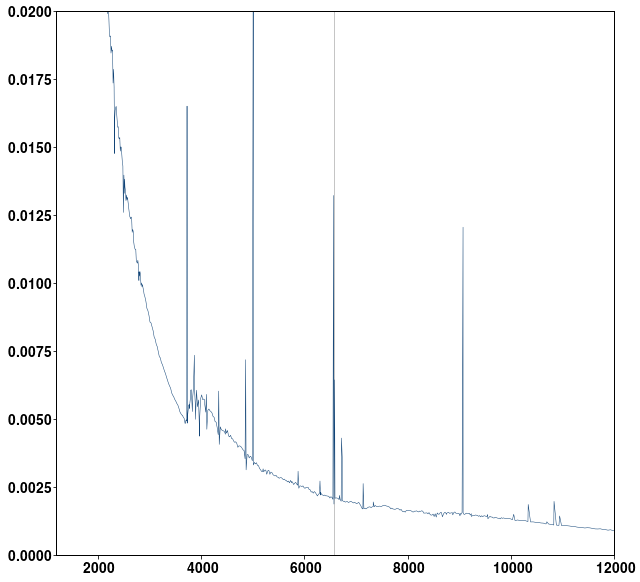

In [98]:
axvline(6562.8, ls="-", lw=0.75, color="0.7")
SEDs.get(10).plot(lw=0.5)
ax = gca()
ax.set_xlim(1200,12000)
ax.set_ylim(0,0.02)